In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pickle as pickle

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
cd gdrive/My Drive/maml_developmental_encoding-main/

/content/gdrive/My Drive/maml_developmental_encoding-main


In [4]:
from indirect_maml import task

In [5]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Tue Jul  6 11:57:58 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Definitions

## Encodings

In [6]:
def get_MNIST_direct_encoding_parameters(device=None):
    
    if device is None:
        device = torch.device("cpu")
    
    generator_parameters = {}
    directly_encoded_parameters = {
        "W0" : torch.nn.Parameter(torch.randn(784,784).to(device)*np.sqrt(2/784)),
        "W1" : torch.nn.Parameter(torch.randn(784,10).to(device)*np.sqrt(2/784)),
        "B0" : torch.nn.Parameter(torch.zeros(784).to(device)),
        "B1" : torch.nn.Parameter(torch.zeros(10).to(device)),
    }
        
    return generator_parameters,directly_encoded_parameters

def get_MNIST_direct_encoding_parameters_3layer(device=None):
    
    if device is None:
        device = torch.device("cpu")
    
    generator_parameters = {}
    directly_encoded_parameters = {
        "W0" : torch.nn.Parameter(torch.randn(784,784).to(device)*np.sqrt(2/784)),
        "W1" : torch.nn.Parameter(torch.randn(784,784).to(device)*np.sqrt(2/784)),
        "W2" : torch.nn.Parameter(torch.randn(784,5).to(device)*np.sqrt(2/784)),
        "B0" : torch.nn.Parameter(torch.zeros(784).to(device)),
        "B1" : torch.nn.Parameter(torch.zeros(784).to(device)),
        "B2" : torch.nn.Parameter(torch.zeros(5).to(device)),
    }
        
    return generator_parameters,directly_encoded_parameters

def dummy_generate_net(generator_parameters):
    return {}



def get_MNIST_simple_GEM_parameters(device=None):
    """
    This function returns the parameters of the indirectly encoded model
    There are 2 kinds of parameters:
     - generator_parameters   they are the parameters which are used to generate (develop) the weights of the direct network
                              These parameters should not be finetuned in when doing indirect maml with direct finetuning
     - directly_encoded_parameters   These are parameters are part of the direct network which we dont wish to generate,
                                     but to encode them directly (for example biases). These parameters should be finetuned.
    """
    if device is None:
        device = torch.device("cpu")

    num_genes = 16
    print(num_genes)
        
    generator_parameters = {
        "X0" : torch.nn.Parameter((1.0/np.sqrt(3*num_genes))*torch.randn(784,num_genes).to(device)),# i dont know what is the correct scaling, 0.1 seems all right
        "O0" : torch.nn.Parameter((1.0/num_genes)*torch.randn(num_genes,num_genes).to(device)), # by correct scaling i mean so the generated net have 1 gain
        "X1" : torch.nn.Parameter((1.0/np.sqrt(3*num_genes))*torch.randn(784,num_genes).to(device)),
        "O1" : torch.nn.Parameter((1.0/num_genes)*torch.randn(num_genes,num_genes).to(device)),
        "X2" : torch.nn.Parameter((1.0/np.sqrt(3*num_genes))*torch.randn(10,num_genes).to(device)),
    }

    generator_parameters["Scaling1"] = torch.tensor(calculate_reference_scaling(torch.matmul(torch.matmul(generator_parameters["X0"],generator_parameters["O0"]),generator_parameters["X1"].T))).to(device)
    generator_parameters["Scaling2"] = torch.tensor(calculate_reference_scaling(torch.matmul(torch.matmul(generator_parameters["X1"],generator_parameters["O0"]),generator_parameters["X2"].T))).to(device)
  
    
    directly_encoded_parameters = {
        "B0" : torch.nn.Parameter(torch.zeros(784).to(device)),
        "B1" : torch.nn.Parameter(torch.zeros(10).to(device)),
    }
    
    return generator_parameters,directly_encoded_parameters

def generate_MNIST_net_simple_GEM(generator_parameters):
    G = generator_parameters # alias for shorter code
    
    generated_weights = {
        "W0" : G["Scaling1"]*torch.matmul(torch.matmul(G["X0"],G["O0"]),G["X1"].T),
        "W1" : G["Scaling2"]*torch.matmul(torch.matmul(G["X1"],G["O0"]),G["X2"].T),
    }
    
    return generated_weights

def get_MNIST_simple_GEM_parameters_3layer(device=None):
    """
    This function returns the parameters of the indirectly encoded model
    There are 2 kinds of parameters:
     - generator_parameters   they are the parameters which are used to generate (develop) the weights of the direct network
                              These parameters should not be finetuned in when doing indirect maml with direct finetuning
     - directly_encoded_parameters   These are parameters are part of the direct network which we dont wish to generate,
                                     but to encode them directly (for example biases). These parameters should be finetuned.
    """
    if device is None:
        device = torch.device("cpu")

    num_genes = 50
    print(num_genes)
        
    generator_parameters = {
        "X0" : torch.nn.Parameter((1.0/np.sqrt(3*num_genes))*torch.randn(784,num_genes).to(device)),# i dont know what is the correct scaling, 0.1 seems all right
        "O0" : torch.nn.Parameter((1.0/num_genes)*torch.randn(num_genes,num_genes).to(device)), # by correct scaling i mean so the generated net have 1 gain
        "X1" : torch.nn.Parameter((1.0/np.sqrt(3*num_genes))*torch.randn(784,num_genes).to(device)),
        "X2" : torch.nn.Parameter((1.0/np.sqrt(3*num_genes))*torch.randn(784,num_genes).to(device)),
        "X3" : torch.nn.Parameter((1.0/np.sqrt(3*num_genes))*torch.randn(10,num_genes).to(device)),
    }

    generator_parameters["Scaling1"] = torch.tensor(calculate_reference_scaling(torch.matmul(torch.matmul(generator_parameters["X0"],generator_parameters["O0"]),generator_parameters["X1"].T))).to(device)
    generator_parameters["Scaling2"] = torch.tensor(calculate_reference_scaling(torch.matmul(torch.matmul(generator_parameters["X1"],generator_parameters["O0"]),generator_parameters["X2"].T))).to(device)
    generator_parameters["Scaling3"] = torch.tensor(calculate_reference_scaling(torch.matmul(torch.matmul(generator_parameters["X2"],generator_parameters["O0"]),generator_parameters["X3"].T))).to(device)
  
    
    directly_encoded_parameters = {
        "B0" : torch.nn.Parameter(torch.zeros(784).to(device)),
        "B1" : torch.nn.Parameter(torch.zeros(784).to(device)),
        "B2" : torch.nn.Parameter(torch.zeros(10).to(device)),
    }
    
    return generator_parameters,directly_encoded_parameters

def generate_MNIST_net_simple_GEM_3layer(generator_parameters):
    G = generator_parameters # alias for shorter code
    
    generated_weights = {
        "W0" : G["Scaling1"]*torch.matmul(torch.matmul(G["X0"],G["O0"]),G["X1"].T),
        "W1" : G["Scaling2"]*torch.matmul(torch.matmul(G["X1"],G["O0"]),G["X2"].T),
        "W2" : G["Scaling3"]*torch.matmul(torch.matmul(G["X2"],G["O0"]),G["X3"].T),
    }
    
    return generated_weights


def forward_MNIST_net(x,net_parameters):
    x = torch.nn.functional.linear(x, net_parameters["W0"].T, net_parameters["B0"])
    x = torch.relu(x)
    x = torch.nn.functional.linear(x, net_parameters["W1"].T, net_parameters["B1"])
    return x
    
def forward_MNIST_3layernet(x,net_parameters):
    x = torch.nn.functional.linear(x, net_parameters["W0"].T, net_parameters["B0"])
    x = torch.relu(x)
    x = torch.nn.functional.linear(x, net_parameters["W1"].T, net_parameters["B1"])
    x = torch.relu(x)
    x = torch.nn.functional.linear(x, net_parameters["W2"].T, net_parameters["B2"])
    return x


In [8]:
def gaussian_filters(shape, positions, isigma):
    if positions.is_cuda:
      ranges = [torch.linspace(-1.0, 1.0, d).to(torch.device("cuda:0")) for d in shape]
    else:
      ranges = [torch.linspace(-1.0, 1.0, d) for d in shape]
    coords = torch.cartesian_prod(*ranges)
    dists = torch.cdist(coords, positions)
    if isinstance(isigma, torch.Tensor): 
        isigma = isigma.unsqueeze(0)
    y = torch.exp(-(dists * isigma) ** 2)
    return y.view(*shape, positions.shape[0])

def uniform(*shape):
    return 2 * torch.rand(*shape) - 1

def calculate_reference_scaling(weights, init_fn=torch.nn.init.kaiming_normal_):
    ref_weights = torch.empty(weights.size()).T
    init_fn(ref_weights)
    return std(ref_weights) / std(weights)

def std(array):
    return max(array.std().item(), 1e-9)


def get_MNIST_spatial_GEM_parameters(device=None):
    """
    This function returns the parameters of the indirectly encoded model
    There are 2 kinds of parameters:
     - generator_parameters   they are the parameters which are used to generate (develop) the weights of the direct network
                              These parameters should not be finetuned in when doing indirect maml with direct finetuning
     - directly_encoded_parameters   These are parameters are part of the direct network which we dont wish to generate,
                                     but to encode them directly (for example biases). These parameters should be finetuned.
    """
    if device is None:
        device = torch.device("cpu")

    num_genes = 71
    print(num_genes)
    sigma = 0.3
    generator_parameters = {
        "G0" : torch.nn.Parameter(torch.atanh(uniform(num_genes, 2).to(device))),# i dont know what is the correct scaling, 0.1 seems all right
        "S0" : torch.nn.Parameter(-np.log(sigma) * torch.ones(num_genes).to(device)),# i dont know what is the correct scaling, 0.1 seems all right
        "O0" : torch.nn.Parameter((1.0/num_genes)*(torch.randn(num_genes,num_genes).to(device))), # by correct scaling i mean so the generated net have 1 gain
        "G1" : torch.nn.Parameter(torch.atanh(uniform(num_genes, 2).to(device))),# i dont know what is the correct scaling, 0.1 seems all right
        "S1" : torch.nn.Parameter(-np.log(sigma) * torch.ones(num_genes).to(device)),# i dont know what is the correct scaling, 0.1 seems all right
        "O1" : torch.nn.Parameter((1.0/num_genes)*(torch.randn(num_genes,num_genes).to(device))),
        "X2" : torch.nn.Parameter((1.0/np.sqrt(3*num_genes))*torch.randn(10,num_genes).to(device)),
    }

    X_input = gaussian_filters([28,28],torch.tanh(generator_parameters["G0"]), torch.exp(generator_parameters["S0"])).view(784,num_genes)
    X_hidden = gaussian_filters([28,28],torch.tanh(generator_parameters["G1"]), torch.exp(generator_parameters["S1"])).view(784,num_genes)

    generator_parameters["Scaling1"] = torch.tensor(calculate_reference_scaling(torch.matmul(torch.matmul(X_input,generator_parameters["O0"]),X_hidden.T))).to(device)
    generator_parameters["Scaling2"] = torch.tensor(calculate_reference_scaling(torch.matmul(torch.matmul(X_hidden,generator_parameters["O0"]),generator_parameters["X2"].T))).to(device)
    
    directly_encoded_parameters = {
        "B0" : torch.nn.Parameter(torch.zeros(784).to(device)),
        "B1" : torch.nn.Parameter(torch.zeros(10).to(device)),
    }
    
    return generator_parameters,directly_encoded_parameters

def generate_MNIST_net_spatial_GEM(generator_parameters):
    G = generator_parameters # alias for shorter code

    X_input = gaussian_filters([28,28],torch.tanh(G["G0"]), torch.exp(G["S0"])).view(784,G['G0'].shape[0])
    X_hidden = gaussian_filters([28,28],torch.tanh(G["G1"]), torch.exp(G["S1"])).view(784,G['G1'].shape[0])

    generated_weights = {
        "W0" : G["Scaling1"]*torch.matmul(torch.matmul(X_input,G["O0"]),X_hidden.T),
        "W1" : G["Scaling2"]*torch.matmul(torch.matmul(X_hidden,G["O0"]),G["X2"].T),
    }
    
    return generated_weights

def get_MNIST_spatial_GEM_parameters_3layer(device=None):
    """
    This function returns the parameters of the indirectly encoded model
    There are 2 kinds of parameters:
     - generator_parameters   they are the parameters which are used to generate (develop) the weights of the direct network
                              These parameters should not be finetuned in when doing indirect maml with direct finetuning
     - directly_encoded_parameters   These are parameters are part of the direct network which we dont wish to generate,
                                     but to encode them directly (for example biases). These parameters should be finetuned.
    """
    if device is None:
        device = torch.device("cpu")

    num_genes = 100
    print(num_genes)
    sigma = 0.3
    generator_parameters = {
        "G0" : torch.nn.Parameter(torch.atanh(uniform(num_genes, 2).to(device))),# i dont know what is the correct scaling, 0.1 seems all right
        "S0" : torch.nn.Parameter(-np.log(sigma) * torch.ones(num_genes).to(device)),# i dont know what is the correct scaling, 0.1 seems all right
        "O0" : torch.nn.Parameter((1.0/num_genes)*(torch.randn(num_genes,num_genes).to(device))), # by correct scaling i mean so the generated net have 1 gain
        "G1" : torch.nn.Parameter(torch.atanh(uniform(num_genes, 2).to(device))),# i dont know what is the correct scaling, 0.1 seems all right
        "S1" : torch.nn.Parameter(-np.log(sigma) * torch.ones(num_genes).to(device)),# i dont know what is the correct scaling, 0.1 seems all right
        "G2" : torch.nn.Parameter(torch.atanh(uniform(num_genes, 2).to(device))),# i dont know what is the correct scaling, 0.1 seems all right
        "S2" : torch.nn.Parameter(-np.log(sigma) * torch.ones(num_genes).to(device)),# i dont know what is the correct scaling, 0.1 seems all right
        "X3" : torch.nn.Parameter((1.0/np.sqrt(3*num_genes))*torch.randn(5,num_genes).to(device)),
    }

    X_input = gaussian_filters([28,28],torch.tanh(generator_parameters["G0"]), torch.exp(generator_parameters["S0"])).view(784,num_genes)
    X_hidden = gaussian_filters([28,28],torch.tanh(generator_parameters["G1"]), torch.exp(generator_parameters["S1"])).view(784,num_genes)
    X_hidden2 = gaussian_filters([28,28],torch.tanh(generator_parameters["G2"]), torch.exp(generator_parameters["S2"])).view(784,num_genes)

    generator_parameters["Scaling1"] = torch.tensor(calculate_reference_scaling(torch.matmul(torch.matmul(X_input,generator_parameters["O0"]),X_hidden.T))).to(device)
    generator_parameters["Scaling2"] = torch.tensor(calculate_reference_scaling(torch.matmul(torch.matmul(X_hidden,generator_parameters["O0"]),X_hidden2.T))).to(device)
    generator_parameters["Scaling3"] = torch.tensor(calculate_reference_scaling(torch.matmul(torch.matmul(X_hidden2,generator_parameters["O0"]),generator_parameters["X3"].T))).to(device)

    
    directly_encoded_parameters = {
        "B0" : torch.nn.Parameter(torch.zeros(784).to(device)),
        "B1" : torch.nn.Parameter(torch.zeros(784).to(device)),
        "B2" : torch.nn.Parameter(torch.zeros(5).to(device)),
    }
    
    return generator_parameters,directly_encoded_parameters

def generate_MNIST_net_spatial_GEM_3layer(generator_parameters):
    G = generator_parameters # alias for shorter code

    X_input = gaussian_filters([28,28],torch.tanh(G["G0"]), torch.exp(G["S0"])).view(784,G['G0'].shape[0])
    X_hidden = gaussian_filters([28,28],torch.tanh(G["G1"]), torch.exp(G["S1"])).view(784,G['G1'].shape[0])
    X_hidden2 = gaussian_filters([28,28],torch.tanh(G["G2"]), torch.exp(G["S2"])).view(784,G['G2'].shape[0])

    generated_weights = {
        "W0" : torch.matmul(torch.matmul(X_input,G["O0"]),X_hidden.T),
        "W1" : torch.matmul(torch.matmul(X_hidden,G["O0"]),X_hidden2.T),
        "W2" : torch.matmul(torch.matmul(X_hidden2,G["O0"]),G["X3"].T),
    }
    
    return generated_weights

## Finetuning Definitions

In [9]:
def finetuning_end_to_end(generator_parameters,directly_encoded_parameters,batch_data,generate_fn,forward_fn,config):
    support_x,support_y,query_x,query_y = batch_data
    adapted_test_losses = []
    meta_batch_adapted_test_accuracies = []
    
    original_parameters = {**generator_parameters,**directly_encoded_parameters}
    
    for task_i in range(support_x.shape[0]):
        current_parameters = original_parameters
        for adaptaion_i in range(config["num_adaptation_steps"]):
            # for end to end, we regenerate the weights every adaptation step
            generated_weights = generate_fn(current_parameters)
            net_parameters = {**current_parameters,**generated_weights}
            out = forward_fn(support_x[task_i],net_parameters)
            loss = torch.nn.functional.cross_entropy(out,support_y[task_i])
            
            # we differentiate with respect to the generator parameters, and not the generated weights
            gradients = torch.autograd.grad(loss, current_parameters.values(),retain_graph=True)
            
            adapted_params = {}
            for grad,(name,param) in zip(gradients, current_parameters.items()):
                modified_param = param - fine_tuning_lr * grad
                adapted_params[name] = modified_param

            current_parameters = adapted_params
            
        # after the last gradient step
        # calculate the adapted test loss
        generated_weights = generate_fn(current_parameters)
        net_parameters = {**current_parameters,**generated_weights}
        out = forward_fn(query_x[task_i],net_parameters)
        adapted_test_loss = torch.nn.functional.cross_entropy(out,query_y[task_i])
        adapted_test_losses.append(adapted_test_loss)
        
        with torch.no_grad():
            pred_q = torch.nn.functional.softmax(out, dim=1).argmax(dim=1)
            correct = torch.eq(pred_q, query_y[task_i]).sum().item()
            meta_batch_adapted_test_accuracies.append(float(correct)/pred_q.numel())

    mean_adapted_test_losses = torch.mean(torch.stack(adapted_test_losses))
    mean_adapted_test_accuracies = np.mean(meta_batch_adapted_test_accuracies)
    return mean_adapted_test_losses,mean_adapted_test_accuracies
                
        

def finetuning_generated_params_only(generator_parameters,directly_encoded_parameters,batch_data,generate_fn,forward_fn,config):
    support_x,support_y,query_x,query_y = batch_data
    adapted_test_losses = []
    meta_batch_adapted_test_accuracies = []
    
    # if we finetune the direct parameters only, we only need to generate the network once
    original_generated_weights = generate_fn(generator_parameters)
    original_net_parameters = {**directly_encoded_parameters,**original_generated_weights}
    
    for task_i in range(support_x.shape[0]):
        current_net_parameters = original_net_parameters
        for adaptaion_i in range(config["num_adaptation_steps"]):
            out = forward_fn(support_x[task_i],current_net_parameters)
            loss = torch.nn.functional.cross_entropy(out,support_y[task_i])

            # we differentiate with respect to the generated weights (and directly encoded parts of the net)
            gradients = torch.autograd.grad(loss, current_net_parameters.values(),retain_graph=True)

            adapted_params = {}
            for grad,(name,param) in zip(gradients, current_net_parameters.items()):
                modified_param = param - fine_tuning_lr * grad
                adapted_params[name] = modified_param

            current_net_parameters = adapted_params
        
        # after the last gradient step
        # calculate the adapted test loss
        out = forward_fn(query_x[task_i],current_net_parameters)
        adapted_test_loss = torch.nn.functional.cross_entropy(out,query_y[task_i])
        adapted_test_losses.append(adapted_test_loss)

        with torch.no_grad():
            pred_q = torch.nn.functional.softmax(out, dim=1).argmax(dim=1)
            correct = torch.eq(pred_q, query_y[task_i]).sum().item()
            meta_batch_adapted_test_accuracies.append(float(correct)/pred_q.numel())

    mean_adapted_test_losses = torch.mean(torch.stack(adapted_test_losses))
    mean_adapted_test_accuracies = np.mean(meta_batch_adapted_test_accuracies)
    return mean_adapted_test_losses,mean_adapted_test_accuracies
    

# Adam Runs

In [ ]:

device = torch.device("cuda:3")

# MAML main loop
config = {
    "FINETUNE_DIRECT_WEIGHTS" : False,
    "ENCODING" : "simple_GEM",  # "direct", "simple_GEM"
}

if config["ENCODING"] == "simple_GEM":
    get_model_fn = get_MNIST_simple_GEM_parameters
    generate_fn = generate_MNIST_net_simple_GEM
    forward_fn = forward_MNIST_net
else:
    get_model_fn = get_MNIST_direct_encoding_parameters
    generate_fn = dummy_generate_net
    forward_fn = forward_MNIST_net

generator_parameters,directly_encoded_parameters = get_model_fn(device)

meta_parameters = {**generator_parameters,**directly_encoded_parameters}
meta_optim = torch.optim.Adam(meta_parameters.values(), lr=0.0001)

num_adaptation_steps = 2
fine_tuning_lr = 0.05

all_losses = []
all_accuracies = []

for meta_i in range(25000):
    support_x,support_y,query_x,query_y = task.omniglot_get_meta_batch(meta_batch_size=4,
                                                                       n_way=5,support_k=3,query_k=10,is_test=False)
    support_x = torch.from_numpy(support_x).to(device)
    query_x = torch.from_numpy(query_x).to(device)
    support_y = torch.from_numpy(support_y).to(device)
    query_y = torch.from_numpy(query_y).to(device)
    batch_data = (support_x,support_y,query_x,query_y)

    if config["FINETUNE_DIRECT_WEIGHTS"] is True:
        mean_adapted_test_losses,mean_adapted_test_accuracies = finetuning_generated_params_only(generator_parameters,directly_encoded_parameters,
                                                               batch_data,generate_fn,forward_fn,config)
    else:
        mean_adapted_test_losses,mean_adapted_test_accuracies = finetuning_end_to_end(generator_parameters,directly_encoded_parameters,
                                                    batch_data,generate_fn,forward_fn,config)
        
    # Now we have the adapted_test_losses, we can calucalte the meta gradient    
    all_losses.append(mean_adapted_test_losses.detach().cpu().view(-1)[0])
    all_accuracies.append(mean_adapted_test_accuracies)
    if meta_i % 50 == 0:
        print(meta_i,mean_adapted_test_accuracies,mean_adapted_test_losses.detach().cpu().view(-1)[0])
    
    meta_optim.zero_grad()
    mean_adapted_test_losses.backward()
    meta_optim.step()
    
    
    
    


RuntimeError: ignored

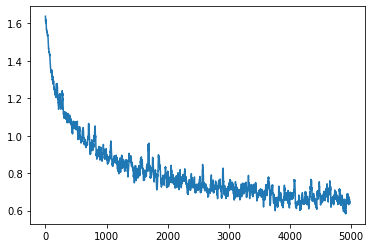

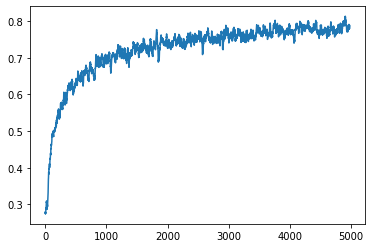

In [ ]:
# direct
# lr=0.002
plt.plot(np.convolve(all_losses,np.ones(20)/20.0,mode="valid"))
plt.show()
plt.plot(np.convolve(all_accuracies,np.ones(20)/20.0,mode="valid"))

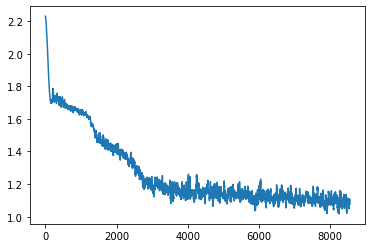

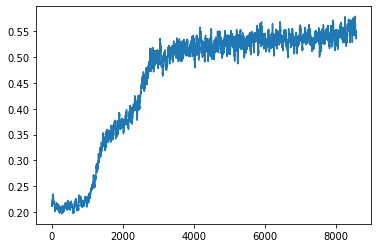

In [ ]:
# simple GEM
# end to end
# lr=0.0001
plt.plot(np.convolve(all_losses,np.ones(20)/20.0,mode="valid"))
plt.show()
plt.plot(np.convolve(all_accuracies,np.ones(20)/20.0,mode="valid"))

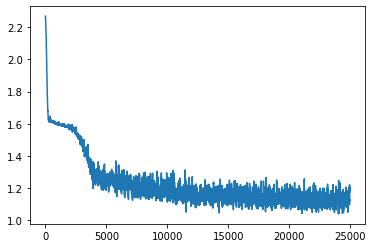

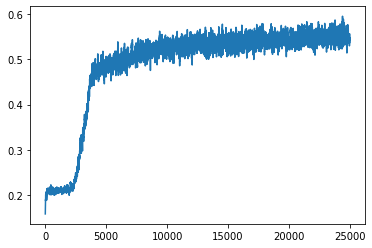

In [ ]:
# simple GEM
# adapt direct parameters
# lr=0.0001
plt.plot(np.convolve(all_losses,np.ones(20)/20.0,mode="valid"))
plt.show()
plt.plot(np.convolve(all_accuracies,np.ones(20)/20.0,mode="valid"))

# Dani Runs

## 2 Layer Runs

In [ ]:
#losses_storage = {}
#accuracies_storage = {}

with open('/content/gdrive/My Drive/LongRuns', 'rb') as f:
  losses_storage,accuracies_storage = pickle.load(f)

In [ ]:
losses_storage.keys()

dict_keys(['spatial_GEM_20compression_0', 'spatial_GEM_20compression_1', 'spatial_GEM_20compression_2', 'spatial_GEM_20compression_3', 'spatial_GEM_20compression_4', 'simple_GEM_10compression_0', 'simple_GEM_10compression_1', 'simple_GEM_10compression_2', 'simple_GEM_10compression_3', 'simple_GEM_10compression_4', 'direct_10compression_0', 'direct_10compression_1', 'direct_10compression_2', 'direct_10compression_3', 'direct_10compression_4'])

In [ ]:

device = torch.device("cuda:0")
for num_reps_local in range (5):
  # MAML main loop
  config = {
      "FINETUNE_DIRECT_WEIGHTS" : True,
      "ENCODING" : "spatial_GEM",  # "direct", "simple_GEM", "spatial_GEM"
  }

  if config["ENCODING"] == "simple_GEM":
      get_model_fn = get_MNIST_simple_GEM_parameters
      generate_fn = generate_MNIST_net_simple_GEM
      forward_fn = forward_MNIST_net
  elif config["ENCODING"] == "spatial_GEM":
      get_model_fn = get_MNIST_spatial_GEM_parameters
      generate_fn = generate_MNIST_net_spatial_GEM
      forward_fn = forward_MNIST_net
  else:
      get_model_fn = get_MNIST_direct_encoding_parameters
      generate_fn = dummy_generate_net
      forward_fn = forward_MNIST_net

  generator_parameters,directly_encoded_parameters = get_model_fn(device)

  meta_parameters = {**generator_parameters,**directly_encoded_parameters}
  meta_optim = torch.optim.Adam(meta_parameters.values(), lr=0.0001)

  num_adaptation_steps = 2
  fine_tuning_lr = 0.05

  all_losses = []
  all_accuracies = []
  for meta_i in range(50000):
  #for meta_i in range(25000):
      support_x,support_y,query_x,query_y = task.omniglot_get_meta_batch(meta_batch_size=4,
                                                                        n_way=5,support_k=3,query_k=10,is_test=False)
      support_x = torch.from_numpy(support_x).to(device)
      query_x = torch.from_numpy(query_x).to(device)
      support_y = torch.from_numpy(support_y).to(device)
      query_y = torch.from_numpy(query_y).to(device)
      batch_data = (support_x,support_y,query_x,query_y)

      if config["FINETUNE_DIRECT_WEIGHTS"] is True:
          mean_adapted_test_losses,mean_adapted_test_accuracies = finetuning_generated_params_only(generator_parameters,directly_encoded_parameters,
                                                                batch_data,generate_fn,forward_fn,config)
      else:
          mean_adapted_test_losses,mean_adapted_test_accuracies = finetuning_end_to_end(generator_parameters,directly_encoded_parameters,
                                                      batch_data,generate_fn,forward_fn,config)
          
      # Now we have the adapted_test_losses, we can calucalte the meta gradient    
      all_losses.append(mean_adapted_test_losses.detach().cpu().view(-1)[0])
      all_accuracies.append(mean_adapted_test_accuracies)
      if meta_i % 50 == 0:
          print(meta_i,mean_adapted_test_accuracies,mean_adapted_test_losses.detach().cpu().view(-1)[0])
      
      meta_optim.zero_grad()
      mean_adapted_test_losses.backward()
      meta_optim.step()

  losses_storage[config["ENCODING"]+"_100compression_"+str(num_reps_local)] = all_losses
  accuracies_storage[config["ENCODING"]+"_100compression_"+str(num_reps_local)] = all_accuracies
  #losses_storage[config["ENCODING"]+"_"+str(num_reps_local)] = all_losses
  #accuracies_storage[config["ENCODING"]+"_"+str(num_reps_local)] = all_accuracies

Streaming output truncated to the last 5000 lines.
200 0.49000000000000005 tensor(1.2574)
250 0.48500000000000004 tensor(1.3433)
300 0.5650000000000001 tensor(1.0774)
350 0.54 tensor(1.3253)
400 0.61 tensor(1.1460)
450 0.52 tensor(1.4608)
500 0.525 tensor(1.4608)
550 0.51 tensor(1.3159)
600 0.505 tensor(1.2443)
650 0.65 tensor(0.9638)
700 0.59 tensor(1.1895)
750 0.665 tensor(0.9404)
800 0.605 tensor(1.0817)
850 0.64 tensor(0.9467)
900 0.6050000000000001 tensor(1.1744)
950 0.63 tensor(1.0877)
1000 0.5449999999999999 tensor(1.1302)
1050 0.515 tensor(1.7939)
1100 0.615 tensor(1.3827)
1150 0.7 tensor(0.9574)
1200 0.6699999999999999 tensor(0.8817)
1250 0.6150000000000001 tensor(0.9888)
1300 0.6950000000000001 tensor(0.9782)
1350 0.655 tensor(1.0571)
1400 0.675 tensor(0.9536)
1450 0.675 tensor(0.8932)
1500 0.635 tensor(0.9930)
1550 0.5750000000000001 tensor(1.3173)
1600 0.54 tensor(1.0508)
1650 0.64 tensor(0.9415)
1700 0.72 tensor(0.7532)
1750 0.625 tensor(0.9113)
1800 0.6900000000000001 ten

In [ ]:
with open('/content/gdrive/My Drive/LongRuns', 'wb') as f:
  pickle.dump([losses_storage,accuracies_storage], f)

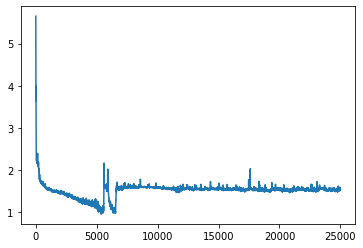

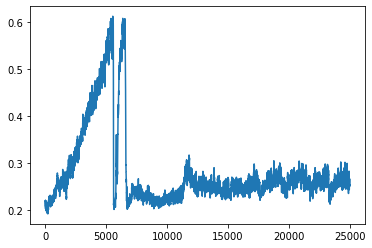

In [ ]:
 # spatial GEM
# lr=0.001
plt.plot(np.convolve(all_losses,np.ones(20)/20.0,mode="valid"))
plt.show()
plt.plot(np.convolve(all_accuracies,np.ones(20)/20.0,mode="valid"))

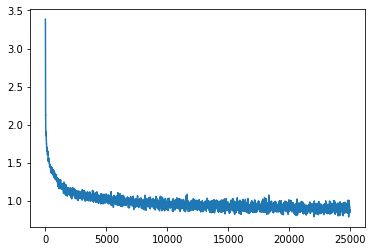

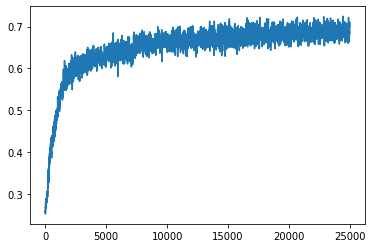

In [ ]:
# spatial GEM with finetuning
# 25 genes
# lr=0.0001
plt.plot(np.convolve(all_losses,np.ones(20)/20.0,mode="valid"))
plt.show()
plt.plot(np.convolve(all_accuracies,np.ones(20)/20.0,mode="valid"))

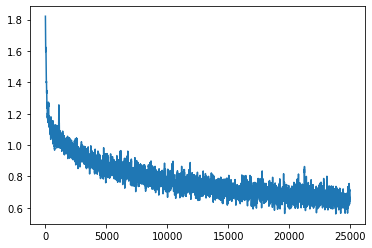

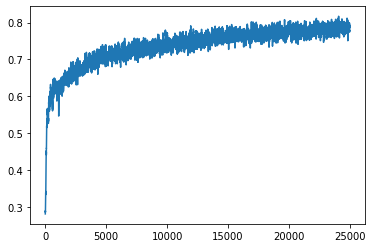

In [ ]:
# spatial GEM with finetuning
# 30 genes
# lr=0.0005
plt.plot(np.convolve(all_losses,np.ones(20)/20.0,mode="valid"))
plt.show()
plt.plot(np.convolve(all_accuracies,np.ones(20)/20.0,mode="valid"))

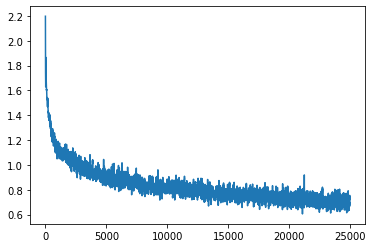

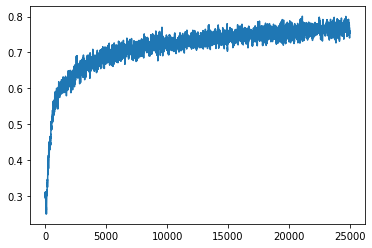

In [ ]:
# spatial GEM with finetuning
# 30 genes
# Share O Matrix
# lr=0.0005
plt.plot(np.convolve(all_losses,np.ones(20)/20.0,mode="valid"))
plt.plot(np.convolve(all_accuracies,np.ones(20)/20.0,mode="valid"))

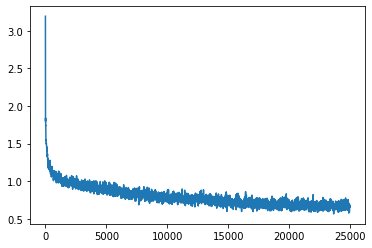

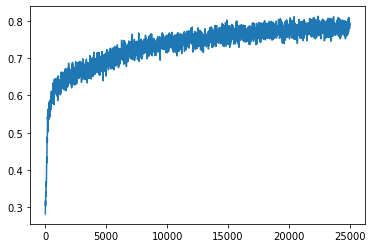

In [ ]:
# spatial GEM with finetuning
# 40 genes
# Share O Matrix
# lr=0.0001
plt.plot(np.convolve(all_losses,np.ones(20)/20.0,mode="valid"))
plt.show()
plt.plot(np.convolve(all_accuracies,np.ones(20)/20.0,mode="valid"))

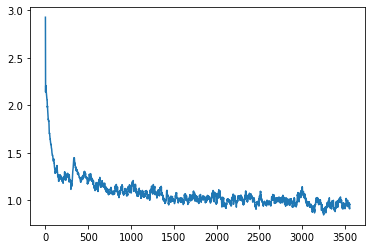

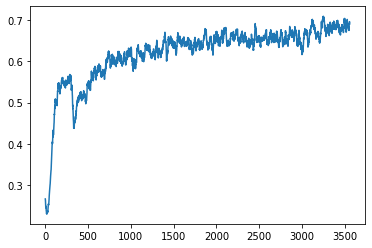

In [ ]:
# spatial GEM with finetuning
# 168 genes
# Share O Matrix
# lr=0.0001
plt.plot(np.convolve(all_losses,np.ones(20)/20.0,mode="valid"))
plt.show()
plt.plot(np.convolve(all_accuracies,np.ones(20)/20.0,mode="valid"))

### 2 layer Plots

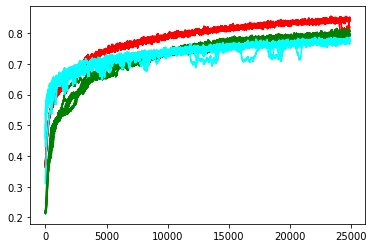

In [ ]:
convolutionTerm = 150.0

with open('/content/gdrive/My Drive/runs', 'rb') as f:
  losses_storage,accuracies_storage = pickle.load(f)

for key,accuracy in accuracies_storage.items():
  if key.split('_')[0] == 'direct':
    plt.plot(np.convolve(accuracy,np.ones(int(convolutionTerm))/convolutionTerm,mode="valid"),color='red')
  elif key.split('_')[0] == 'spatial':
    if key.split('_')[2] == '20compression':
      plt.plot(np.convolve(accuracy,np.ones(int(convolutionTerm))/convolutionTerm,mode="valid"),color='cyan')
    #else:
    #  plt.plot(np.convolve(accuracy,np.ones(int(convolutionTerm))/convolutionTerm,mode="valid"),color='blue')
  elif key.split('_')[0] == 'simple':
    plt.plot(np.convolve(accuracy,np.ones(int(convolutionTerm))/convolutionTerm,mode="valid"),color='green')


plt.title('Short Runs')

In [ ]:
accuracies_storage.keys()

dict_keys(['spatial_GEM_20compression_0', 'spatial_GEM_20compression_1', 'spatial_GEM_20compression_2', 'spatial_GEM_20compression_3', 'spatial_GEM_20compression_4', 'simple_GEM_10compression_0', 'simple_GEM_10compression_1', 'simple_GEM_10compression_2', 'simple_GEM_10compression_3', 'simple_GEM_10compression_4', 'direct_10compression_0', 'direct_10compression_1', 'direct_10compression_2', 'direct_10compression_3', 'direct_10compression_4', 'simple_GEM_25compression_0', 'simple_GEM_25compression_1', 'simple_GEM_25compression_2', 'simple_GEM_25compression_3', 'simple_GEM_25compression_4', 'spatial_GEM_100compression_0', 'spatial_GEM_100compression_1', 'spatial_GEM_100compression_2', 'spatial_GEM_100compression_3', 'spatial_GEM_100compression_4'])

Text(0.5, 1.0, 'LongRuns')

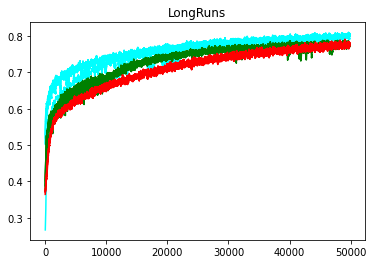

In [ ]:
#with open('/content/gdrive/My Drive/LongRuns', 'rb') as f:
#  losses_storage,accuracies_storage = pickle.load(f)

convolutionTerm = 150.0

for key,accuracy in accuracies_storage.items():
  if key.split('_')[0] == 'direct':
    plt.plot(np.convolve(accuracy,np.ones(int(convolutionTerm))/convolutionTerm,mode="valid"),color='red',label = 'Direct')
  elif key.split('_')[0] == 'spatial':
    if key.split('_')[2] == '20compression':
      plt.plot(np.convolve(accuracy,np.ones(int(convolutionTerm))/convolutionTerm,mode="valid"),color='cyan',label = '10x S-GEM')
    #else:
    #  plt.plot(np.convolve(accuracy,np.ones(int(convolutionTerm))/convolutionTerm,mode="valid"),color='blue')
  elif key.split('_')[0] == 'simple':
    if key.split('_')[2] == '10compression':
      plt.plot(np.convolve(accuracy,np.ones(int(convolutionTerm))/convolutionTerm,mode="valid"),color='green',label = '10x GEM')
    #if key.split('_')[2] == '25compression':
    #  plt.plot(np.convolve(accuracy,np.ones(int(convolutionTerm))/convolutionTerm,mode="valid"),color='blue',label = '25x GEM')


plt.title('LongRuns')
#plt.legend()

EOFError: ignored

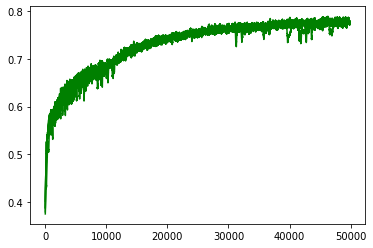

In [ ]:
with open('/content/gdrive/My Drive/runs', 'rb') as f:
  losses_storage,accuracies_storage = pickle.load(f)
convolutionTerm = 150.0

for key,accuracy in accuracies_storage.items():
  if key.split('_')[0] == 'simple':
    plt.plot(np.convolve(accuracy,np.ones(int(convolutionTerm))/convolutionTerm,mode="valid"),color='green')

with open('/content/gdrive/My Drive/LongRuns', 'rb') as f:
  losses_storage,accuracies_storage = pickle.load(f)

for key,accuracy in accuracies_storage.items():
  if key.split('_')[0] == 'simple':
    plt.plot(np.convolve(accuracy,np.ones(int(convolutionTerm))/convolutionTerm,mode="valid"),color='blue')

## 3 Layer Runs

In [10]:
losses_storage = {}
accuracies_storage = {}

#with open('/content/gdrive/My Drive/ShortRuns_3Layer', 'rb') as f:
#  losses_storage,accuracies_storage = pickle.load(f)

In [ ]:

device = torch.device("cuda:0")
for num_reps_local in range(1):
  # MAML main loop
  config = {
      "FINETUNE_DIRECT_WEIGHTS" : True,
      "ENCODING" : "spatial_GEM",  # "direct", "simple_GEM", "spatial_GEM"

      # LOGGING
      "LOG_TEST_SCORE_FREQUENCY" : 250, # how often run test batch
      "META_TEST_BATCH_SIZE" : 32, 
      "NUM_TEST_META_BATCHES" : 10, # we break it up into many smaller batches to save memory  
      "num_adaptation_steps": 3,
  }

  if config["ENCODING"] == "simple_GEM":
      get_model_fn = get_MNIST_simple_GEM_parameters_3layer
      generate_fn = generate_MNIST_net_simple_GEM_3layer
      forward_fn = forward_MNIST_3layernet
  elif config["ENCODING"] == "spatial_GEM":
      get_model_fn = get_MNIST_spatial_GEM_parameters_3layer
      generate_fn = generate_MNIST_net_spatial_GEM_3layer
      forward_fn = forward_MNIST_3layernet
  else:
      get_model_fn = get_MNIST_direct_encoding_parameters_3layer
      generate_fn = dummy_generate_net
      forward_fn = forward_MNIST_3layernet

  generator_parameters,directly_encoded_parameters = get_model_fn(device)

  meta_parameters = {**generator_parameters,**directly_encoded_parameters}
  meta_optim = torch.optim.Adam(meta_parameters.values(), lr=10**(-5))

  fine_tuning_lr = 0.1

  all_losses = []
  all_accuracies = []
  all_test_test_losses = []
  all_test_test_accuracies = []
  all_checkpoint_losses = []
  all_checkpoint_accuracies = []
  x_axis_for_checkpoint_plots = []

  x_axis_for_test_plots = []
  #for meta_i in range(50000):
  for meta_i in range(25000):
      support_x,support_y,query_x,query_y = task.omniglot_get_meta_batch(meta_batch_size=128,
                                                                        n_way=5,support_k=1,query_k=10,is_test=False)
      support_x = torch.from_numpy(support_x).to(device)
      query_x = torch.from_numpy(query_x).to(device)
      support_y = torch.from_numpy(support_y).to(device)
      query_y = torch.from_numpy(query_y).to(device)
      batch_data = (support_x,support_y,query_x,query_y)

      if config["FINETUNE_DIRECT_WEIGHTS"] is True:
          mean_adapted_test_losses,mean_adapted_test_accuracies = finetuning_generated_params_only(generator_parameters,directly_encoded_parameters,
                                                                batch_data,generate_fn,forward_fn,config)
      else:
          mean_adapted_test_losses,mean_adapted_test_accuracies = finetuning_end_to_end(generator_parameters,directly_encoded_parameters,
                                                      batch_data,generate_fn,forward_fn,config)
          
      # Now we have the adapted_test_losses, we can calucalte the meta gradient    
      all_losses.append(mean_adapted_test_losses.detach().cpu().view(-1)[0])
      all_accuracies.append(mean_adapted_test_accuracies)
      #if meta_i % 50 == 0:
      #    print(meta_i,mean_adapted_test_accuracies,mean_adapted_test_losses.detach().cpu().view(-1)[0])

      # before updating the parameters, run the test batch if it is time
      TIME_TO_TEST = (meta_i % config["LOG_TEST_SCORE_FREQUENCY"]) == 0
      if (TIME_TO_TEST is True):
          num_test_batches = config["NUM_TEST_META_BATCHES"]
          
          # to save memory, do it in batches
          all_t_mean_adapted_test_losses = []
          all_t_mean_adapted_test_accuracies = []
          for test_b_i in range(num_test_batches):
              t_support_x,t_support_y,t_query_x,t_query_y = task.omniglot_get_meta_batch(meta_batch_size=64,n_way=5,
                                                                          support_k=1,query_k=10,is_test=True)
              t_support_x = torch.from_numpy(t_support_x).to(device)
              t_query_x = torch.from_numpy(t_query_x).to(device)
              t_support_y = torch.from_numpy(t_support_y).to(device)
              t_query_y = torch.from_numpy(t_query_y).to(device)
              t_batch_data = (t_support_x,t_support_y,t_query_x,t_query_y)

              if config["FINETUNE_DIRECT_WEIGHTS"] is True:
                t_mean_adapted_test_losses,t_mean_adapted_test_accuracies = finetuning_generated_params_only(generator_parameters,directly_encoded_parameters, 
                                                      t_batch_data,generate_fn,forward_fn,config)
              else:
                t_mean_adapted_test_losses,t_mean_adapted_test_accuracies = finetuning_end_to_end(generator_parameters,directly_encoded_parameters,
                                                      t_batch_data,generate_fn,forward_fn,config)

              all_t_mean_adapted_test_losses.append(t_mean_adapted_test_losses.detach().cpu().view(-1)[0])
              all_t_mean_adapted_test_accuracies.append(t_mean_adapted_test_accuracies)

          all_t_mean_adapted_test_losses = np.mean(all_t_mean_adapted_test_losses)
          all_t_mean_adapted_test_accuracies = np.mean(all_t_mean_adapted_test_accuracies)

          if TIME_TO_TEST is True:
              all_test_test_losses.append(all_t_mean_adapted_test_losses)
              all_test_test_accuracies.append(all_t_mean_adapted_test_accuracies)
              x_axis_for_test_plots.append(meta_i)
              print(meta_i,all_t_mean_adapted_test_accuracies,all_t_mean_adapted_test_losses)

      
      meta_optim.zero_grad()
      mean_adapted_test_losses.backward()
      meta_optim.step()

  losses_storage[config["ENCODING"]+"_50compression_"+str(num_reps_local)] = all_test_test_losses
  accuracies_storage[config["ENCODING"]+"_50compression_"+str(num_reps_local)] = all_test_test_accuracies
  #losses_storage[config["ENCODING"]+"_"+str(num_reps_local)] = all_losses
  #accuracies_storage[config["ENCODING"]+"_"+str(num_reps_local)] = all_accuracies

100
0 0.28671875 7.159968
250 0.45321875 1.3211359
500 0.5019374999999999 1.2419045
750 0.52878125 1.2033165
1000 0.562625 1.1369163
1250 0.56634375 1.12565
1500 0.58440625 1.0835593
1750 0.5921875000000001 1.075261
2000 0.5958749999999999 1.063618
2250 0.6109375 1.0455545
2500 0.6064375 1.0807259
2750 0.58615625 1.1143314
3000 0.5801875 1.1215543
3250 0.5782812500000001 1.1233464
3500 0.5973124999999999 1.0936925
3750 0.5885 1.1057428
4000 0.5993125 1.0915247
4250 0.61053125 1.0603912
4500 0.6151875 1.0573807
4750 0.6149687500000001 1.0466012
5000 0.6305625000000001 1.0287745
5250 0.61703125 1.0457928
5500 0.6313124999999999 1.0311325
5750 0.6369687500000001 1.0002213
6000 0.64546875 0.9972569
6250 0.64540625 0.993049
6500 0.64415625 0.997272
6750 0.64171875 0.98924303
7000 0.6554374999999999 0.9597683
7250 0.6613125 0.9484622
7500 0.65709375 0.95853484
7750 0.65725 0.9668806
8000 0.6680937499999999 0.9361762


In [1]:
support_y.shape

NameError: ignored

In [ ]:
      get_model_fn = get_MNIST_direct_encoding_parameters_3layer
      generate_fn = dummy_generate_net
      forward_fn = forward_MNIST_3layernet

In [ ]:
  generator_parameters,directly_encoded_parameters = get_model_fn(device)


In [ ]:
z = generate_fn(generator_parameters)

In [ ]:
z['W1'].var()

tensor(0.0025, device='cuda:0', grad_fn=<VarBackward>)

(array([4.14000e+02, 2.09200e+03, 8.70600e+03, 5.00260e+04, 3.12965e+05,
        2.15800e+05, 2.24130e+04, 1.81900e+03, 3.35000e+02, 8.60000e+01]),
 array([-0.34017783, -0.2698805 , -0.19958317, -0.12928583, -0.0589885 ,
         0.01130883,  0.08160616,  0.1519035 ,  0.22220084,  0.29249817,
         0.3627955 ], dtype=float32),
 <a list of 10 Patch objects>)

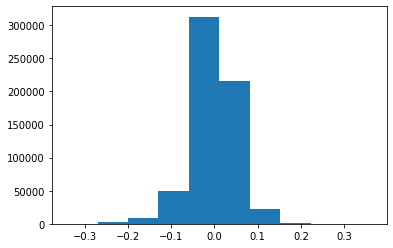

In [ ]:
plt.hist(z['W1'].cpu().detach().reshape(-1).numpy())

(array([4.00000e+01, 1.10800e+03, 1.54690e+04, 9.08820e+04, 2.13183e+05,
        2.03289e+05, 7.79570e+04, 1.19540e+04, 7.55000e+02, 1.90000e+01]),
 array([-0.24741712, -0.19738959, -0.14736207, -0.09733453, -0.04730701,
         0.00272052,  0.05274805,  0.10277557,  0.15280311,  0.20283063,
         0.25285816], dtype=float32),
 <a list of 10 Patch objects>)

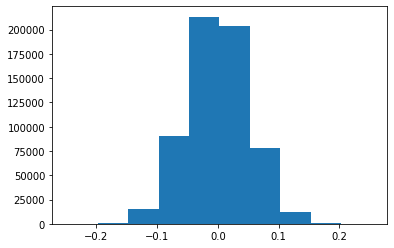

In [ ]:
plt.hist(directly_encoded_parameters['W1'].cpu().detach().reshape(-1).numpy())

In [ ]:
directly_encoded_parameters['W1'].var()

tensor(0.0025, device='cuda:0', grad_fn=<VarBackward>)

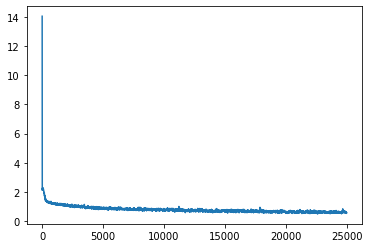

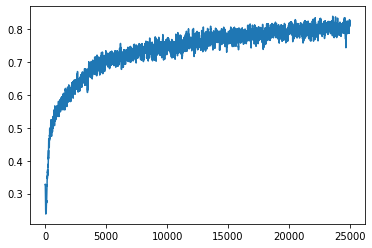

In [ ]:
 # spatial GEM 2 updates
# lr=0.001
plt.plot(np.convolve(all_losses,np.ones(20)/20.0,mode="valid"))
plt.show()
plt.plot(np.convolve(all_accuracies,np.ones(20)/20.0,mode="valid"))

In [ ]:
cd MyDrive

/content/gdrive/MyDrive


In [ ]:
cd maml_developmental_encoding-main/

/content/gdrive/MyDrive/maml_developmental_encoding-main


In [ ]:
cd 

SyntaxError: ignored

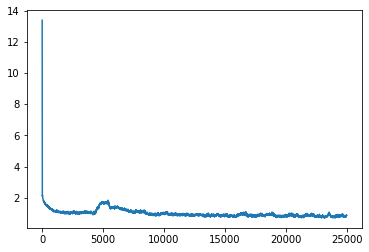

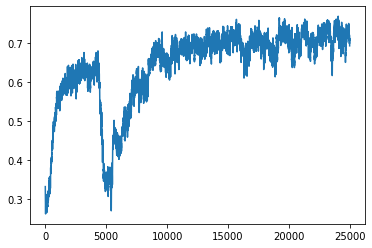

In [ ]:
 # spatial GEM 3 updates
# lr=0.001
plt.plot(np.convolve(all_losses,np.ones(20)/20.0,mode="valid"))
plt.show()
plt.plot(np.convolve(all_accuracies,np.ones(20)/20.0,mode="valid"))

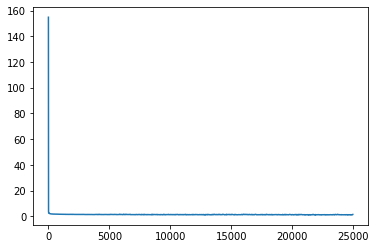

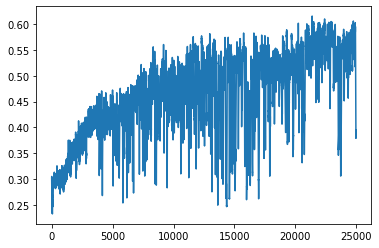

In [ ]:
 # spatial GEM 1 updates
# lr=0.001
plt.plot(np.convolve(all_losses,np.ones(20)/20.0,mode="valid"))
plt.show()
plt.plot(np.convolve(all_accuracies,np.ones(20)/20.0,mode="valid"))